In [3]:
df = pd.read_csv("Churn_Modelling.csv")
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Drop unnecessary columns
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis=1)

# Target variable
target = "Exited"

# Separate features and target
X = df.drop(target, axis=1)
y = df[target]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None
         RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  1000

In [7]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

from sklearn.impute import SimpleImputer

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:
pipe_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(solver="liblinear"))
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

print("Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Results:
[[1540   53]
 [ 331   76]]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



In [10]:
pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

print("Random Forest Results:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
[[1533   60]
 [ 227  180]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.75      0.44      0.56       407

    accuracy                           0.86      2000
   macro avg       0.81      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



In [15]:
!pip install xgboost


In [17]:
from xgboost import XGBClassifier



In [19]:
pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", XGBClassifier(eval_metric="logloss", random_state=42))
])

pipe_xgb.fit(X_train, y_train)
y_pred_xgb = pipe_xgb.predict(X_test)

print("XGBoost Results:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Results:
[[1502   91]
 [ 207  200]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1593
           1       0.69      0.49      0.57       407

    accuracy                           0.85      2000
   macro avg       0.78      0.72      0.74      2000
weighted avg       0.84      0.85      0.84      2000



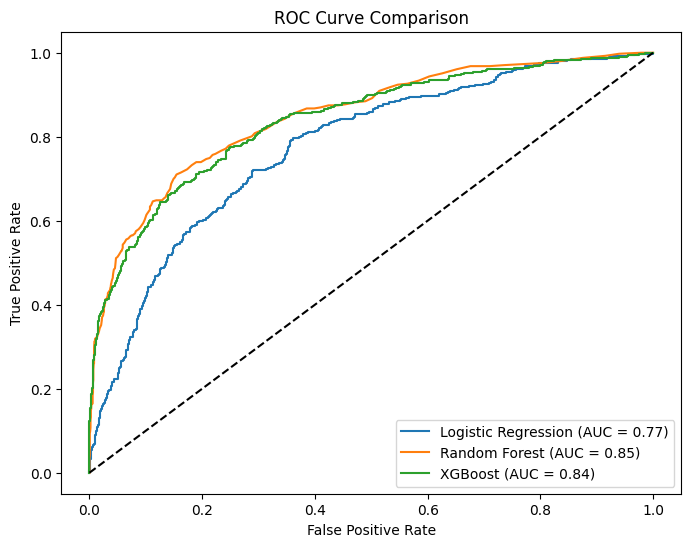

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": pipe_lr,
    "Random Forest": pipe_rf,
    "XGBoost": pipe_xgb
}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [21]:
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": (pipe_lr, y_pred_lr),
    "Random Forest": (pipe_rf, y_pred_rf),
    "XGBoost": (pipe_xgb, y_pred_xgb)
}

for name, (model, pred) in models.items():
    print(f"\n🔹 {name} Accuracy: {accuracy_score(y_test, pred):.4f}")
    print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))



🔹 Logistic Regression Accuracy: 0.8080
ROC AUC: 0.7747655205282323

🔹 Random Forest Accuracy: 0.8565
ROC AUC: 0.8484462891242551

🔹 XGBoost Accuracy: 0.8510
ROC AUC: 0.8391611950933985


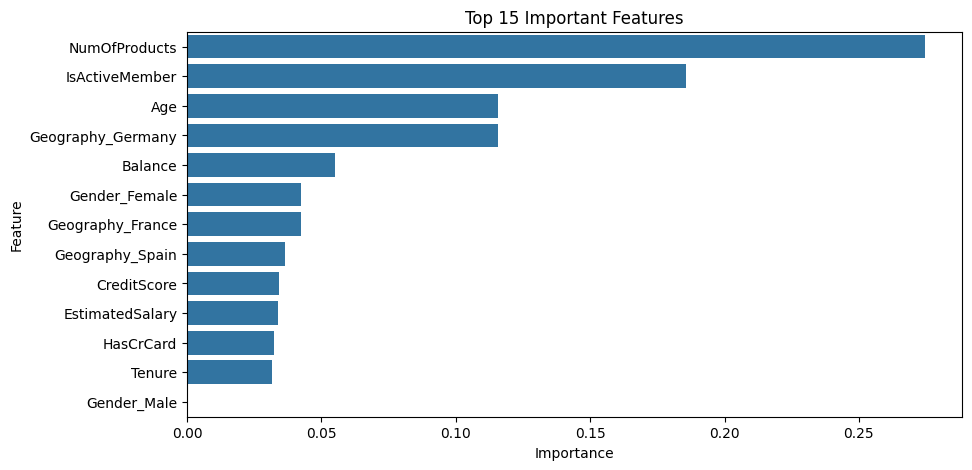

In [22]:
best_model = pipe_xgb.named_steps["clf"]
ohe = pipe_xgb.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(cat_cols)
feature_names = list(num_cols) + list(cat_names)

importances = best_model.feature_importances_
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values("Importance", ascending=False).head(15)

plt.figure(figsize=(10,5))
sns.barplot(x="Importance", y="Feature", data=feat_imp)
plt.title("Top 15 Important Features")
plt.show()


In [23]:
import joblib

joblib.dump(pipe_xgb, "churn_model.pkl")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [24]:
new_data = pd.DataFrame({
    "CreditScore": [600],
    "Geography": ["France"],
    "Gender": ["Female"],
    "Age": [40],
    "Tenure": [3],
    "Balance": [60000],
    "NumOfProducts": [2],
    "HasCrCard": [1],
    "IsActiveMember": [1],
    "EstimatedSalary": [50000]
})

pred = pipe_xgb.predict(new_data)
print("Predicted Churn:", pred)


Predicted Churn: [0]
